In [17]:
from astropy.table import Table, vstack
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic
import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
from RegscorePy import *
from collections import OrderedDict
from radial_distribution_funcs import *

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 100
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)
figure_save_path = 'figures/radial_dist/'

In [3]:
bin_number=14
bin_edges_areas = 10 ** np.linspace(1.0, np.log10(700), num=bin_number + 1)
areas = np.array([])
for i in range(len(bin_edges_areas[:-1])):
    areas = np.append(areas, (bin_edges_areas[i + 1] ** 2 - bin_edges_areas[i] ** 2) * np.pi)
    

### Total Satellite Sample (all $z$-bins)

In [20]:
# combine redshift bin
field_names = ['ELAIS_deep','DEEP_deep','COSMOS_deep']

sat_z_cut = 3.0
path = 'new_radial_dist_2023/distribution/total_sample_test_nov13/'
# path = 'new_radial_dist_2023/distribution/total_sample_test_c20_dec04/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sample=''  # '' or 'sat' or 'bkg' 
bin_number=14

radial_all = np.zeros(bin_number)
radial_all_err_square = np.zeros(bin_number)
radial_ssf = np.zeros(bin_number)
radial_ssf_err_square = np.zeros(bin_number)
radial_sq = np.zeros(bin_number)
radial_sq_err_square = np.zeros(bin_number)
count_central = 0

bin_centers = np.load(path+'bin_centers_fixed.npy')
for z in [0.4, 0.6, 0.8, 1.0]:
    radial_z_all = combine_deep_fields(field_names,csfq,'all', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
    count_central += radial_z_all[2]
    radial_all += radial_z_all[0]*radial_z_all[2]
    radial_all_err_square += radial_z_all[1]**2*radial_z_all[2]**2
        
    radial_z_ssf = combine_deep_fields(field_names,csfq,'ssf', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
    radial_ssf += radial_z_ssf[0]*radial_z_ssf[2]
    radial_ssf_err_square += radial_z_ssf[1]**2*radial_z_ssf[2]**2
        
    radial_z_sq = combine_deep_fields(field_names,csfq,'sq', masscut_low,masscut_high, z, sat_z_cut=sat_z_cut, path=path, sample=sample, bin_number=bin_number)
    radial_sq += radial_z_sq[0]*radial_z_sq[2]
    radial_sq_err_square += radial_z_sq[1]**2*radial_z_sq[2]**2
    
    if sample != '': 
        sample_show = sample+'_'
    else:
        sample_show = ''
        
    np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_all'+'.txt', (radial_z_all[0],radial_z_all[1]))
    np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_ssf'+'.txt', (radial_z_ssf[0],radial_z_ssf[1]))
    np.savetxt(path+'all_field_'+ sample_show + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_'+ str(z) + '_sq'+'.txt', (radial_z_sq[0],radial_z_sq[1]))

radial_all = (radial_all/count_central, np.sqrt(radial_all_err_square)/count_central)
radial_ssf = (radial_ssf/count_central, np.sqrt(radial_ssf_err_square)/count_central)
radial_sq = (radial_sq/count_central, np.sqrt(radial_sq_err_square)/count_central)
print('No. of centrals',count_central)

np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_all'+'.txt', radial_all)
np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_ssf'+'.txt', radial_ssf)
np.savetxt(path+'all_field_'+ sample_show +str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_'+csfq+'_sq'+'.txt', radial_sq)

No. of centrals 2759.0


### catalog stats figures

In [ ]:
# load in satellite catalogs




In [ ]:
# mass vs z plot



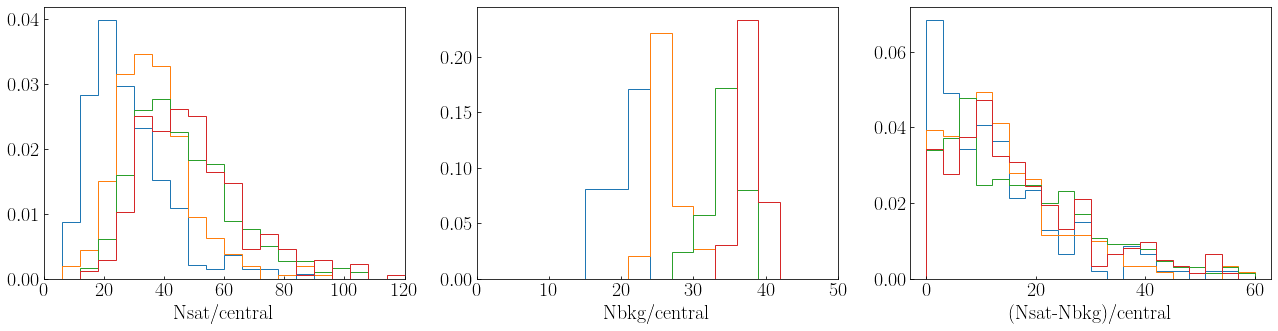

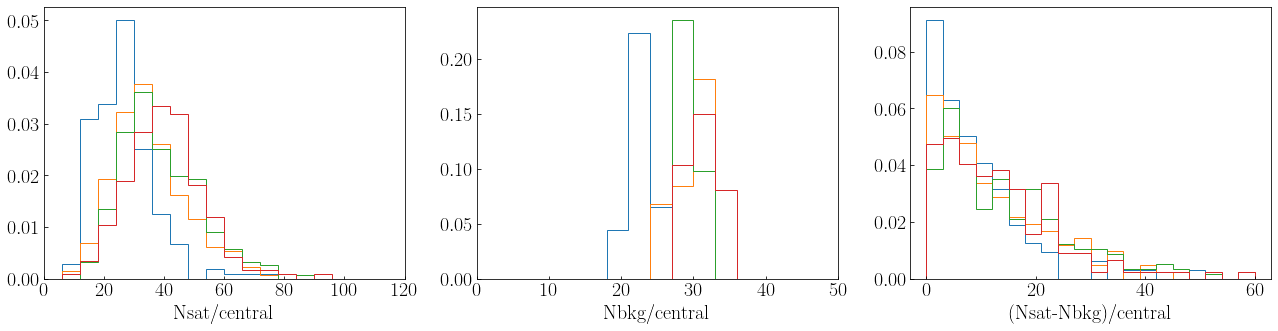

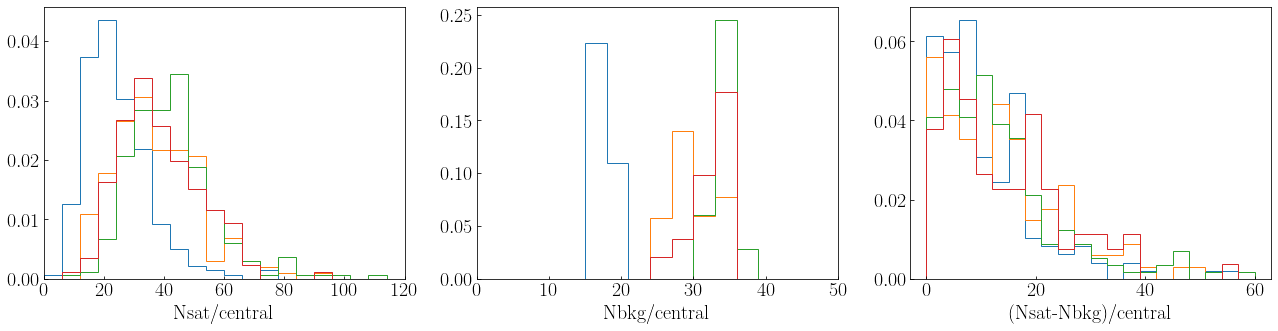

In [17]:
# N/central distribution
for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    fig, axs = plt.subplots(1, 3, figsize=(22, 5))
    for z in [0.4,0.6,0.8,1.0]:
        cat = Table.read('new_radial_dist_2023/central_cat/isolated_'+cat_name+'_3.0_11.3_'+str(z)+'_massive.positions.fits')
        axs[0].hist(cat['n_sat'], histtype='step',range=(0,120),bins=20,density=True)
        axs[1].hist(cat['n_bkg'], histtype='step',range=(0,60),bins=20,density=True)
        axs[2].hist(cat['n_sat']-cat['n_bkg'], histtype='step',range=(0,60),bins=20,density=True)
        
    axs[0].set_xlim([0,120])
    axs[1].set_xlim([0,50])
    axs[0].set_xlabel('Nsat/central', fontsize=20)
    axs[1].set_xlabel('Nbkg/central', fontsize=20)
    axs[2].set_xlabel('(Nsat-Nbkg)/central', fontsize=20)
    

### Results Figures

nfw+sersic [2.337e+02 2.684e-05 6.303e-05 2.652e+01 4.935e-01] [1.970e+01 2.619e-06 1.650e-05 2.747e+00 2.502e-01] 0.5012342791226045
nfw+sersic [3.090e+02 1.148e-05 2.480e-05 3.014e+01 3.348e-01] [4.839e+01 1.908e-06 6.354e-06 3.035e+00 2.703e-01] 0.8239588483495288
nfw+sersic [2.114e+02 1.194e-05 2.000e-02 1.715e+00 1.034e+01] [1.610e+02 1.492e-05 2.156e+00 8.072e+01 1.857e+02] 0.47347138225976054


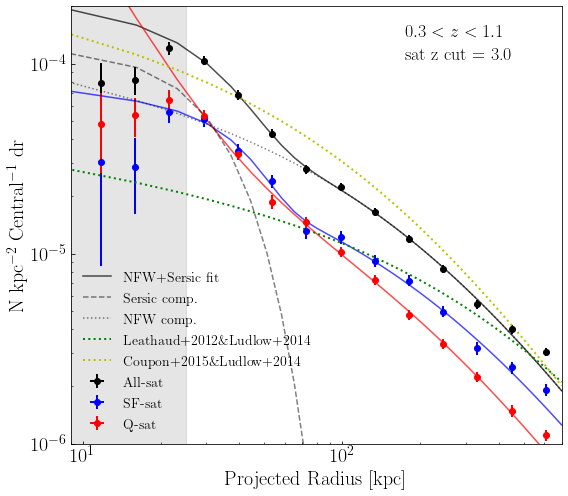

In [4]:
fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
# path = 'new_radial_dist_2023/distribution/total_sample_test_c20_dec04/'
path = 'new_radial_dist_2023/distribution/total_sample_test_nov13/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)

count_radial_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'all'+'.txt')
count_radial_sf_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'ssf'+'.txt')
count_radial_q_allz = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ 'sq'+'.txt')

########
for i, radial in enumerate([count_radial_allz, count_radial_sf_allz, count_radial_q_allz]):
    label='NFW+Sersic fit' if i==0 else ''
    plt.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o'+color[i],label=sat_type[i]+'-sat',linewidth=2)
    
    popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,radial[0],radial[1], 4)
    perr_allz = np.sqrt(np.diag(pcov_allz))
    print('nfw+sersic',popt_allz,perr_allz,chi2_allz/(len(bin_edges)-start+1 - len(popt_allz)))
    plt.plot(fit_x,nfw_sersic(fit_x, popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4]),color[i],alpha=0.7,label=label)
        
popt_allz,pcov_allz,chi2_allz = fit_nfw_sersic(bin_centers,count_radial_allz[0],count_radial_allz[1], 4)
plt.plot(fit_x,sersic(fit_x, popt_allz[2],popt_allz[3],popt_allz[4]),'--k',alpha=0.5,label='Sersic comp.')
plt.plot(fit_x,nfw(fit_x,popt_allz[0],popt_allz[1]),':k',alpha=0.5,label='NFW comp.')

# prediction of rs from DM mass distribution 
# median central mass --> halo mass --> rs
rs_range1 = [647] # m_h from Leathaud et al. 2012
rs_range2 = [156] # m_h from Coupon et al. 2015
references = ['Leathaud+2012\&Ludlow+2014','Coupon+2015\&Ludlow+2014']
colors = ['g','y']
norm_to_value = nfw_sersic(bin_centers[-1], popt_allz[0],popt_allz[1],popt_allz[2],popt_allz[3],popt_allz[4])
for i,rs_range in enumerate([rs_range1,rs_range2]):
    for j,rs in enumerate(rs_range):
        norm_guess = 1e-4
        norm = norm_guess/(nfw(fit_x,rs,norm_guess)[-10]/norm_to_value)
        plt.plot(fit_x,nfw(fit_x,rs,norm),':'+colors[i],linewidth=2,label=references[i] if j==0 else'')
        
plt.annotate(r'$0.3<z<1.1$',xy=([0.68,0.93]),xycoords='axes fraction',fontsize=18,color='k')
plt.annotate('sat z cut = '+str(sat_z_cut),xy=([0.68,0.88]),xycoords='axes fraction',fontsize=18,color='k')
# plt.annotate(sfq_method.replace('_',' '),xy=([0.68,0.82]),xycoords='axes fraction',fontsize=18,color='k')

plt.axvspan(9, 25, alpha=0.1, color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([9,700])
plt.ylim([1e-6,2e-4])
plt.xlabel('Projected Radius [kpc]', fontsize=20)
plt.ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
plt.legend(fontsize=14,frameon=False,loc='lower left')
plt.tight_layout()
plt.savefig(figure_save_path+'number_density_allz.png')



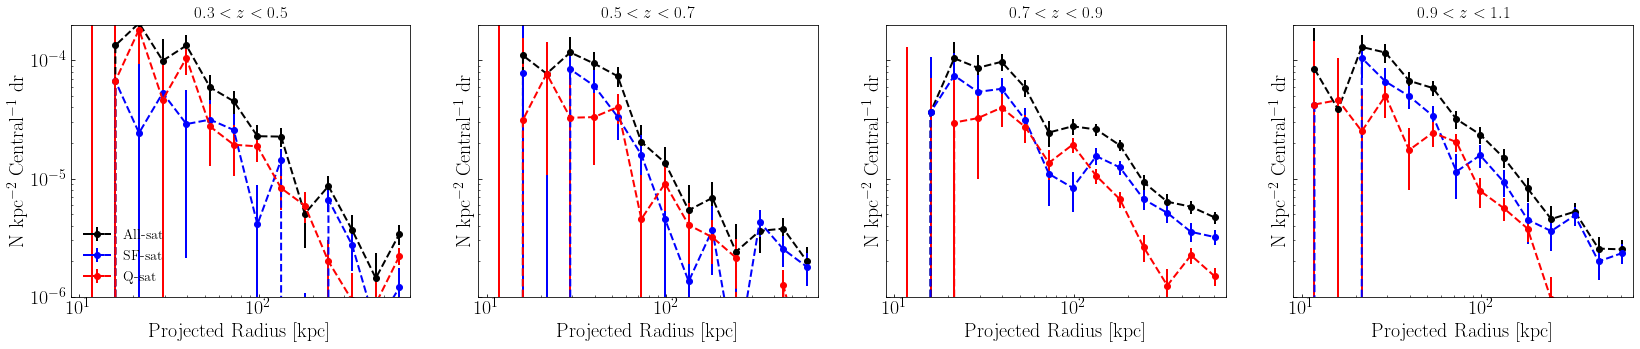

In [37]:
fig, axs = plt.subplots(1, 4, sharex=True,sharey='row', figsize=(28, 5))
# path = 'new_radial_dist_2023/distribution/total_sample_test_Nov13/'
path = 'new_radial_dist_2023/distribution/total_sample_test_c20_dec04/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']

for z_idx,z in enumerate([0.4, 0.6, 0.8, 1.0]): 
    count_radial_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    count_radial_sf_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_ssf'+'.txt')
    count_radial_q_z = np.genfromtxt(path+'all_field_'+str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_sq'+'.txt')
    for i, radial in enumerate([count_radial_z, count_radial_sf_z, count_radial_q_z]):
        axs[z_idx].errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o--'+color[i],label=sat_type[i]+'-sat',linewidth=2)

    axs[z_idx].set_xscale('log')
    axs[z_idx].set_yscale('log')
    axs[z_idx].set_xlim([9,700])
    axs[z_idx].set_ylim([1e-6,2e-4])
    
    axs[z_idx].set_title(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',fontsize=17)
    axs[z_idx].set_xlabel('Projected Radius [kpc]', fontsize=20)
    axs[z_idx].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
    axs[0].legend(fontsize=14,frameon=False,loc='lower left')


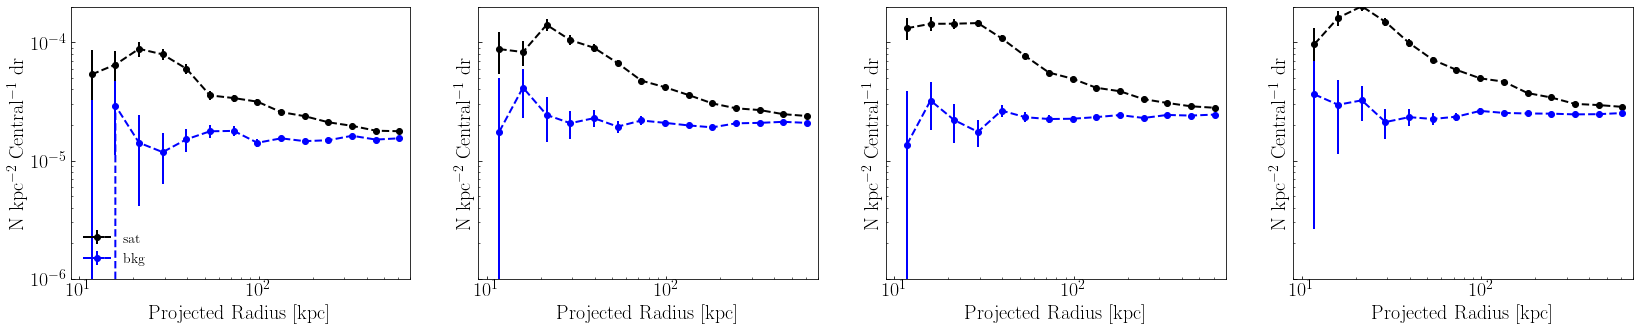

In [21]:
# sat / bkg distribution

fig, axs = plt.subplots(1, 4, sharex=True,sharey='row', figsize=(28, 5))
path = 'new_radial_dist_2023/distribution/total_sample_test_Nov13/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']

for z_idx,z in enumerate([0.4, 0.6, 0.8, 1.0]): 
    count_radial_z = np.genfromtxt(path  + 'all_field_sat_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
    count_radial_z_bkg = np.genfromtxt(path + 'all_field_bkg_' + str(sat_z_cut)+'_'+masscut_low+'_'+masscut_high+'_all_'+ str(z) +'_all'+'.txt')
        
    axs[z_idx].errorbar(bin_centers, count_radial_z[0],yerr=count_radial_z[1],xerr=0,fmt='ok--',label='sat',linewidth=2)
    axs[z_idx].errorbar(bin_centers, count_radial_z_bkg[0],yerr=count_radial_z_bkg[1],xerr=0,fmt='ob--',label='bkg',linewidth=2)
    
    axs[z_idx].set_xscale('log')
    axs[z_idx].set_yscale('log')
    axs[z_idx].set_xlim([9,700])
    axs[z_idx].set_ylim([1e-6,2e-4])
    
    axs[z_idx].set_xlabel('Projected Radius [kpc]', fontsize=20)
    axs[z_idx].set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
    axs[0].legend(fontsize=14,frameon=False,loc='lower left')

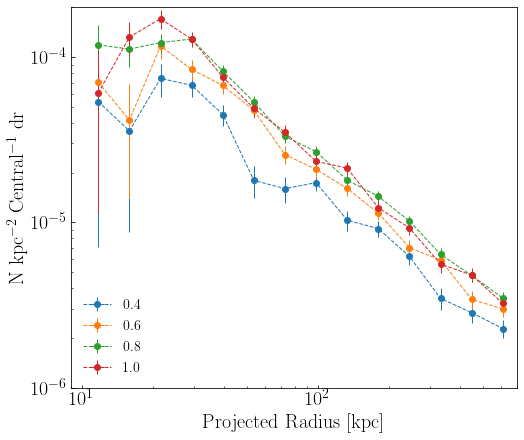

In [56]:
fig, ax = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 7))
path = 'new_radial_dist_2023/distribution/total_sample_test_Nov13/'
masscut_low = '9.5'
masscut_high = '12.0'
csfq='all'
sat_z_cut = 3.0
bin_edges = np.load(path+'bin_edges.npy')
bin_centers = np.load(path+'bin_centers_fixed.npy')
minus = bin_centers - bin_edges[:-1]
plus = bin_edges[1:] - bin_centers

start=4
color=['k','b','r']
sat_type = ['All','SF','Q']
fit_x = np.linspace(2,700,num=100)

for z_idx,z in enumerate([0.4, 0.6, 0.8, 1.0]):
    radial = combine_deep_fields(['DEEP_deep','COSMOS_deep','ELAIS_deep'],'all','all','9.5','12.0', z, sat_z_cut=sat_z_cut, path=path)
    ax.errorbar(bin_centers, radial[0],yerr=radial[1],xerr=0,fmt='o--',linewidth=1,label=str(z))
    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([9,700])
ax.set_ylim([1e-6,2e-4])
ax.set_xlabel('Projected Radius [kpc]', fontsize=20)
ax.set_ylabel('N kpc$^{-2}$ Central$^{-1}$ dr', fontsize=20)
ax.legend(fontsize=14,frameon=False,loc='lower left')

evolving mass cut for centrals
artificial test catalog
start with look at N/central and bkg level (centrals catalog)

mnassive gals z<1.5

PDZs of Guillaume's galaxies(include irac detection)
recompute redshift with Guillaume's PDZ 

go to C20, compare z_G and z_C20, check PDZ (bimodal?) and my redshift for massive galaxies (those who changed massses, or not)
bring in IRAC information? check i-IRAC color! mass cut M>[11.0]
also just plot irac vs z_G_6B (or z_ML)

comptute SMF for Guillaume's catalog !!!
also SMF for 6band photometry

Z_BEST distribution

my mass function is lower --> maybe redshift problem --> use pcat redshifts --> avoid pcat z-problems because of lack of IRAC (meaning massive gals may be not estimated correctly) --> modify some of the pcat redshifts --> maybe rerun phosphoros for some of the galaxies (massive ones)

#### Satellite SMF
mass cut for central: 11.3

In [36]:
def combine_deep_smf(path, ssfq, affix, z): 
    counts_total = 0
    smf_avg_total = np.zeros(20)
    smf_inf_total = np.zeros(20)
    smf_sup_total = np.zeros(20)
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        smf = np.genfromtxt(path+'smf_'+cat_name+'_0.0_0.7_7.0_all_'+ssfq+'_'+z+'_'+affix+'.txt')
    
        count = smf[0]
        smf_avg = smf[1:21]
        smf_inf = smf[21:41]
        smf_sup = smf[41:61]
        
        counts_total += count
        smf_avg_total += smf_avg * count
        smf_inf_total += smf_inf * count
        smf_sup_total += smf_sup * count
    
    smf_avg_threefields = smf_avg_total / counts_total
    smf_inf_threefields = smf_inf_total / counts_total
    smf_sup_threefields = smf_sup_total / counts_total
    
    return counts_total, smf_avg_threefields, smf_inf_threefields, smf_sup_threefields


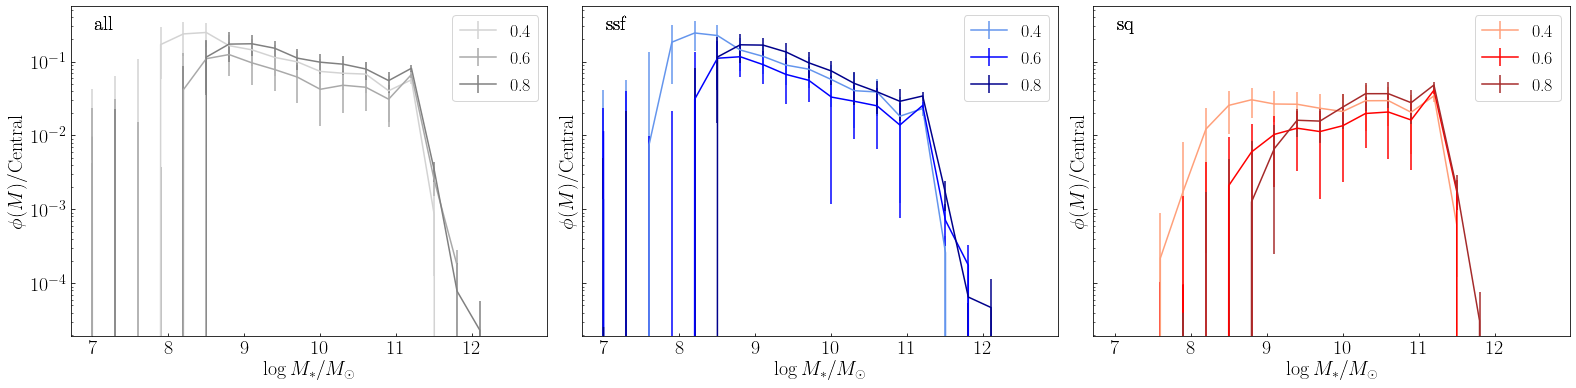

In [37]:
count_type = 'sat'
ssfq = 'all'
fig, axs = plt.subplots(1, 3, sharex=True,sharey='row', figsize=(22, 5.5))
q_colors = ['lightsalmon','red','brown','maroon']
sf_colors = ['cornflowerblue','blue','darkblue','midnightblue']
all_colors  = ['lightgray','darkgray','gray','black']
color_sets = [all_colors, sf_colors, q_colors]

m_bin_left_edges = np.linspace(7.0, 13.0, num=21)[:-1]
for i,ssfq in enumerate(['all','ssf','sq']):
    for z_idx,z in enumerate([0.4,0.6,0.8]):
        n_centrals, smf_avg, smf_inf, smf_sup = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', ssfq, count_type, str(z))
        axs[i].errorbar(m_bin_left_edges,smf_avg/n_centrals,yerr=[smf_avg-smf_inf,smf_sup-smf_avg]/n_centrals,label=str(z),c=color_sets[i][z_idx])

        axs[i].set_yscale('log')
        axs[i].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
        axs[i].set_ylabel('$\phi(M)/\mathrm{Central}$',fontsize=20)
        axs[i].legend(fontsize=18)
        axs[i].annotate(ssfq,xy=([0.05,0.93]),xycoords='axes fraction',fontsize=20,color='k')
plt.tight_layout()

Text(0.5, 0, '$\\log M_*/M_\\odot$')

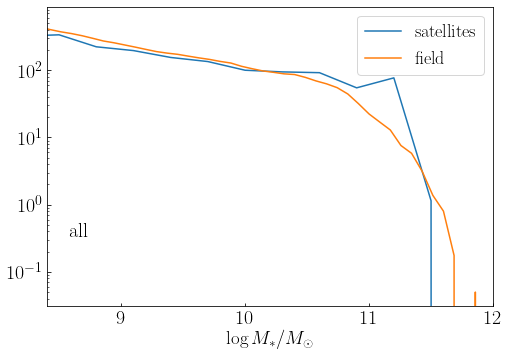

In [38]:
# compare to the field values

bins_field = np.linspace(8,12.2,50)[:-1]
smf_field = np.load('pcat_extinc_smf_nonir_all_0.2_0.5.npy')[0]

ssfq = 'all'
bins_smf = np.linspace(7.0, 13.0, num=21)[:-1]
smf_sat = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', ssfq, count_type, '0.4')[1]

fig, axs = plt.subplots(1, 1, sharex=True,sharey='row', figsize=(8, 5.5))

plt.plot(m_bin_left_edges,smf_sat,label='satellites')
plt.plot(bins_field,smf_field*1.6e4,label='field')
plt.annotate(ssfq,xy=([0.05,0.23]),xycoords='axes fraction',fontsize=20,color='k')

plt.xlim([8.4,12])
plt.yscale('log')
plt.legend(fontsize=18)
plt.xlabel('$\log M_*/M_\odot$',fontsize=19)

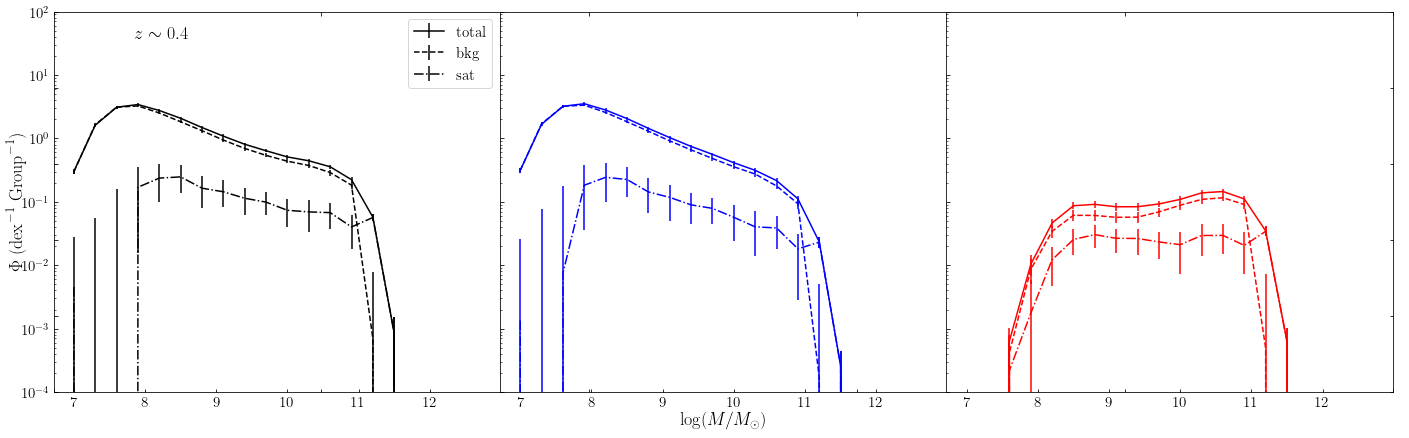

In [39]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(24,7))
path = 'smf_pcat/test_smf_pcat_jan24/'
bin_edges = m_bin_left_edges = np.linspace(7.0, 13.0, num=21)[:-1]
z=0.4
low_r='0.0'; high_r='0.7'

#load data
all_total = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'all', 'total', str(z))
all_bkg = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'all', 'bkg', str(z))
all_sat = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'all', 'sat', str(z))

sf_total = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'ssf', 'total', str(z))
sf_bkg = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'ssf', 'bkg', str(z))
sf_sat = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'ssf', 'sat', str(z))

q_total = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'sq', 'total', str(z))
q_bkg = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'sq', 'bkg', str(z))
q_sat = combine_deep_smf('smf_pcat/test_smf_pcat_jan24/', 'sq', 'sat', str(z))

# all
error = [(all_total[1]-all_total[2])/all_total[0], (all_total[3]-all_total[1])/all_total[0]]
axs[0].errorbar(bin_edges, all_total[1]/all_total[0],yerr=error,fmt='k',label='total')
axs[0].errorbar(bin_edges, all_bkg[1]/all_bkg[0],yerr=error,fmt='--k',label='bkg')
axs[0].errorbar(bin_edges, all_sat[1]/all_sat[0],yerr=error,fmt='-.k',label='sat')
axs[0].annotate(r'$z\sim'+str(z)+'$',xy=([0.18,0.93]),xycoords='axes fraction',fontsize=18,color='k')

#sf
error_sf = [(sf_total[1]-sf_total[2])/sf_total[0], (sf_total[3]-sf_total[1])/sf_total[0]]
axs[1].errorbar(bin_edges, sf_total[1]/sf_total[0],yerr=error_sf,fmt='b')
axs[1].errorbar(bin_edges, sf_bkg[1]/sf_bkg[0],yerr=error_sf,fmt='--b')
axs[1].errorbar(bin_edges, sf_sat[1]/sf_sat[0],yerr=error_sf,fmt='-.b')

# #q
error_q = [(q_total[1]-q_total[2])/q_total[0], (q_total[3]-q_total[1])/q_total[0]]
axs[2].errorbar(bin_edges, q_total[1]/q_total[0],yerr=error_q,fmt='r')
axs[2].errorbar(bin_edges, q_bkg[1]/q_bkg[0],yerr=error_q,fmt='--r')
axs[2].errorbar(bin_edges, q_sat[1]/q_sat[0],yerr=error_q,fmt='-.r')

axs[0].set_yscale('log')
axs[0].set_ylim([1e-4,1e2])
axs[0].legend(fontsize=15)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel(r'$\log(M/M_\odot)$', fontsize=18)
plt.ylabel(r'$\Phi~ (\mathrm{dex}^{-1} ~\mathrm{Group}^{-1})$', fontsize=18)
plt.show()

In [60]:
# check the overall mass function

#### spatial completeness 